In [202]:
from utils import *
import pandas as pd
import datetime as dt

opt_data = pd.read_csv('./data/options.csv')
ibit_data = pd.read_csv('./data/ibit-usd.csv')[["Date", "Adj Close"]]
ibit_data["Date"] = pd.to_datetime(ibit_data["Date"]).dt.tz_localize(None)

opt_data["Expiration_date"] = pd.to_datetime(opt_data["Expiration_date"]).dt.tz_localize(None)
opt_data["lastTradeDate"] = pd.to_datetime(opt_data["lastTradeDate"]).dt.tz_localize(None)

opt_data = opt_data[["contractSymbol", "lastTradeDate", "Expiration_date", "strike", "lastPrice"]]
opt_data["days_to_expiration"] = (opt_data["Expiration_date"] - opt_data['lastTradeDate']).dt.days
opt_data.sort_values(by=["lastTradeDate", "Expiration_date", "strike"], inplace=True)
opt_data

,contractSymbol,lastTradeDate,Expiration_date,strike,lastPrice,days_to_expiration
83,IBIT250221C00036000,2024-11-19 15:28:56,2025-02-21,36.0,17.70,93
44,IBIT250117C00039000,2024-11-19 15:38:41,2025-01-17,39.0,14.75,58
2,IBIT241220C00037000,2024-11-19 18:49:06,2024-12-20,37.0,17.00,30
181,IBIT260116C00049000,2024-11-19 19:02:40,2026-01-16,49.0,20.50,422
87,IBIT250221C00041000,2024-11-19 19:35:35,2025-02-21,41.0,15.39,93
...,...,...,...,...,...,...
20,IBIT241220C00057000,2024-11-22 20:59:38,2024-12-20,57.0,3.83,27
51,IBIT250117C00046000,2024-11-22 20:59:38,2025-01-17,46.0,12.34,55
23,IBIT241220C00060000,2024-11-22 20:59:43,2024-12-20,60.0,2.71,27
150,IBIT250516C00060000,2024-11-22 20:59:47,2025-05-16,60.0,10.65,174


In [203]:
merged_df = pd.merge_ordered(ibit_data, opt_data, left_on="Date", right_on="lastTradeDate")
merged_df[["Date", "Adj Close"]] = merged_df[["Date", "Adj Close"]].fillna(method="ffill")
merged_df.dropna(subset="contractSymbol", inplace=True)
merged_df = merged_df[["Adj Close", "lastTradeDate", "Expiration_date", "strike", "lastPrice", "days_to_expiration"]].reset_index(drop=True)
merged_df

C:\Users\User\AppData\Local\Temp\ipykernel_24772\895202201.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[["Date", "Adj Close"]] = merged_df[["Date", "Adj Close"]].fillna(method="ffill")


,Adj Close,lastTradeDate,Expiration_date,strike,lastPrice,days_to_expiration
0,52.700001,2024-11-19 15:28:56,2025-02-21,36.0,17.70,93.0
1,52.700001,2024-11-19 15:38:41,2025-01-17,39.0,14.75,58.0
2,52.700001,2024-11-19 18:49:06,2024-12-20,37.0,17.00,30.0
3,52.700001,2024-11-19 19:02:40,2026-01-16,49.0,20.50,422.0
4,52.700001,2024-11-19 19:35:35,2025-02-21,41.0,15.39,93.0
...,...,...,...,...,...,...
247,56.490002,2024-11-22 20:59:38,2024-12-20,57.0,3.83,27.0
248,56.490002,2024-11-22 20:59:38,2025-01-17,46.0,12.34,55.0
249,56.490002,2024-11-22 20:59:43,2024-12-20,60.0,2.71,27.0
250,56.490002,2024-11-22 20:59:47,2025-05-16,60.0,10.65,174.0


In [ ]:
def freitas2(S, X, T, r, mi, sigma):
    mi_ST = np.log(S) + T*mi
    sigma_ST = np.sqrt(T)*sigma

    def ret_lin(s, C):
        return (s-(X+C))*(1/(s*sigma_ST*np.sqrt(2*np.pi)))*np.exp(-(np.log(s)-mi_ST)**2/(2*sigma_ST**2))

    def ret_ct(s, C):
        return -C*(1/(s*sigma_ST*np.sqrt(2*np.pi)))*np.exp(-(np.log(s)-mi_ST)**2/(2*sigma_ST**2))

    def diferenca_esperancas(C):
        Pt = quad(ret_ct, 0, X, args=(C))[0]
        Pp = quad(ret_lin, X, X + C, args=(C))[0]
        L = quad(ret_lin, X + C, np.inf, args=(C))[0]
        D = abs(L + Pt + Pp)
        return D

    C_freitas = minimize_scalar(diferenca_esperancas).x * np.exp(-r*T)

    return C_freitas

In [205]:
mi, sigma, r = pd.read_csv('./data/parameters_ibit.csv').values[0]
mi = 0
# r = 0

merged_df["BS"] = merged_df.apply(lambda x: black_scholes(x["Adj Close"], x["strike"], x["days_to_expiration"], r, sigma), axis=1)

merged_df["Freitas"] = merged_df.apply(lambda x: freitas2(x["Adj Close"], x["strike"], x["days_to_expiration"], r, mi, sigma), axis=1)

merged_df

Adj Close       lastTradeDate Expiration_date  strike  lastPrice  \
0    52.700001 2024-11-19 15:28:56      2025-02-21    36.0      17.70   
1    52.700001 2024-11-19 15:38:41      2025-01-17    39.0      14.75   
2    52.700001 2024-11-19 18:49:06      2024-12-20    37.0      17.00   
3    52.700001 2024-11-19 19:02:40      2026-01-16    49.0      20.50   
4    52.700001 2024-11-19 19:35:35      2025-02-21    41.0      15.39   
..         ...                 ...             ...     ...        ...   
247  56.490002 2024-11-22 20:59:38      2024-12-20    57.0       3.83   
248  56.490002 2024-11-22 20:59:38      2025-01-17    46.0      12.34   
249  56.490002 2024-11-22 20:59:43      2024-12-20    60.0       2.71   
250  56.490002 2024-11-22 20:59:47      2025-05-16    60.0      10.65   
251  56.490002 2024-11-22 20:59:55      2027-01-15    30.0      37.70   

     days_to_expiration         BS    Freitas  
0                  93.0  18.204207  20.395183  
1                  58.0  14.874108  16.215086  
2                  30.0  16.007315  16.747850  
3                 422.0  17.996296  26.923754  
4                  93.0  14.363545  16.378896  
..                  ...        ...        ...  
247                27.0   4.097719   4.494502  
248                55.0  12.528890  13.787904  
249                27.0   2.904371   3.221360  
250               174.0   9.917186  12.866942  
251               783.0  34.893912  58.613518  

[252 rows x 8 columns]

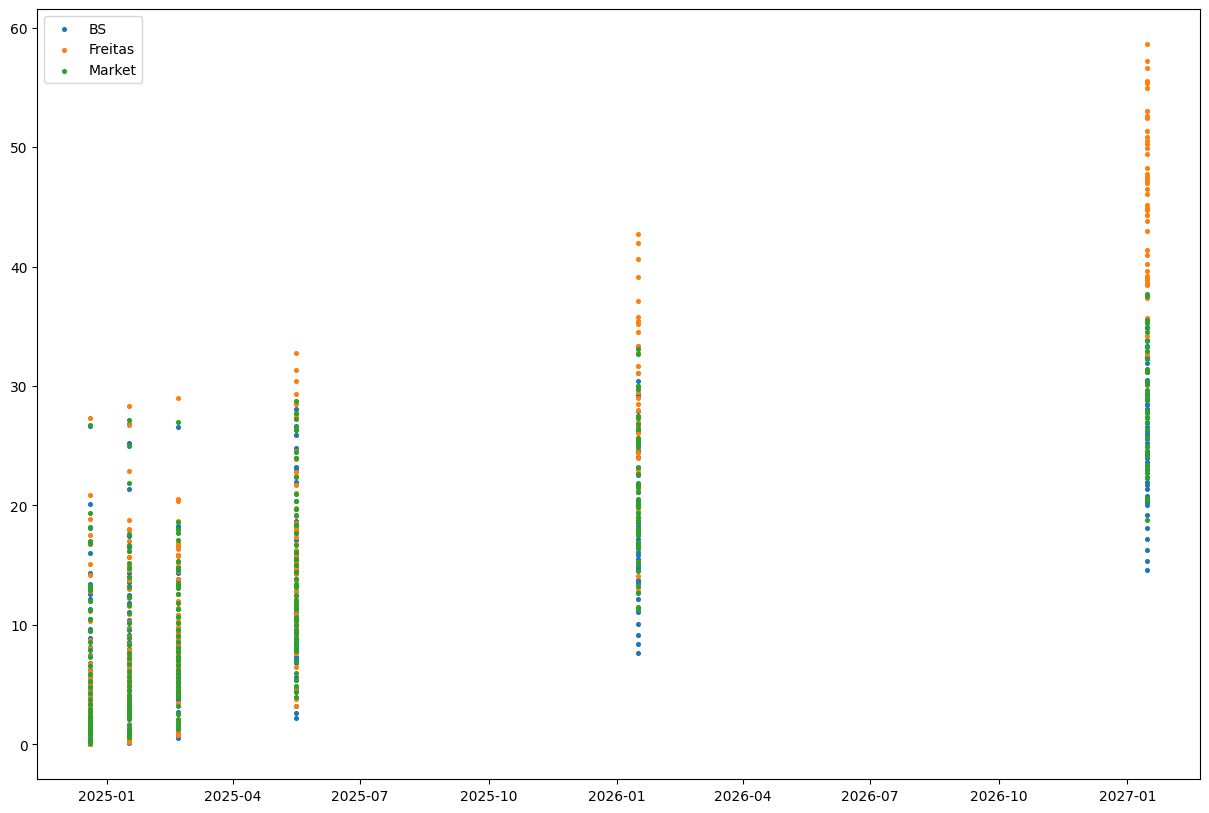

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.scatter(merged_df["Expiration_date"], merged_df["BS"], label="BS", alpha=1, s=7)
plt.scatter(merged_df["Expiration_date"], merged_df["Freitas"], label="Freitas", alpha=1, s=7)
plt.scatter(merged_df["Expiration_date"], merged_df["lastPrice"], label="Market", alpha=1, s=7)

plt.legend()

plt.show()

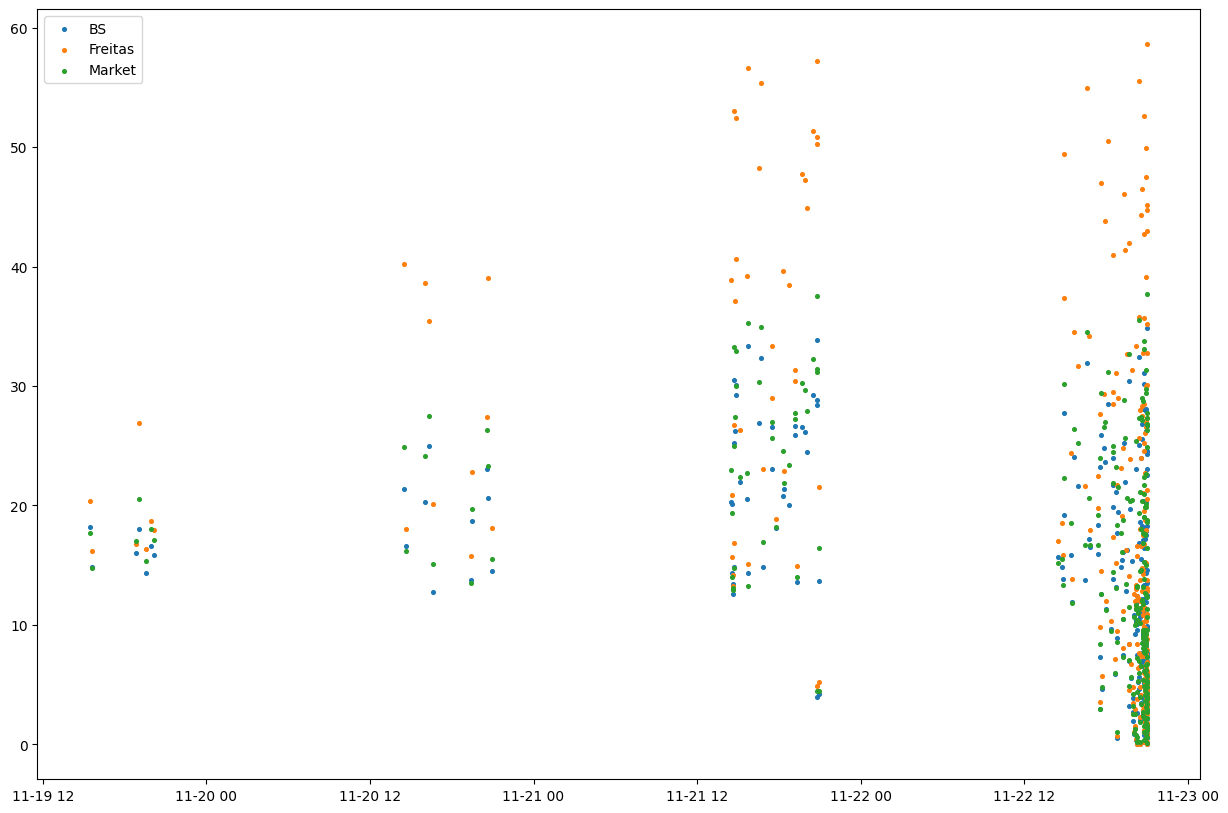

In [207]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.scatter(merged_df["lastTradeDate"], merged_df["BS"], label="BS", alpha=1, s=7)
plt.scatter(merged_df["lastTradeDate"], merged_df["Freitas"], label="Freitas", alpha=1, s=7)
plt.scatter(merged_df["lastTradeDate"], merged_df["lastPrice"], label="Market", alpha=1, s=7)

plt.legend()

plt.show()

In [ ]:
dif_Freitas_BS = np.mean([merged_df['Freitas'] > merged_df['BS']])
dif_Freitas = np.mean(abs(merged_df['Freitas'] - merged_df['lastPrice']))
dif_BS = np.mean(abs(merged_df['BS'] - merged_df['lastPrice']))
dif_Freitas_BS, dif_Freitas, dif_BS

(0.9246031746031746, 4.903113998856221, 1.2773836274363166)